In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

# Text Embeddings with OpenCLIP

This notebook demonstrates how to generate text embeddings using OpenCLIP, similar to how we handle image embeddings in our existing codebase.

In [2]:
import open_clip
import torch
from pymongo import MongoClient
import numpy as np
from iris.config.embedding_pipeline_config_manager import EmbeddingPipelineConfigManager
from iris.config.data_pipeline_config_manager import DataPipelineConfigManager
from iris.embedding_pipeline.embedding_database import EmbeddingDatabase
from iris.data_pipeline.mongodb_manager import MongoDBManager
import iris.utils.data_utils as data_utils



# Initialize CLIP model
model_name = "ViT-B-32"
device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms(
    model_name,
    pretrained="laion2b_s34b_b79k",
    device=device
)
model.eval()

# Initialize embedding database
db_config = EmbeddingPipelineConfigManager().database_config
data_config = DataPipelineConfigManager()
shop_config = data_config.shop_configs["nikolaj_storm"]
mongodb_manager = MongoDBManager(shop_config, data_config.mongodb_config)
embedding_db = EmbeddingDatabase(db_config, shop_config)
embedding_db.load()

# Get data
product_collection = mongodb_manager.get_collection(
    mongodb_manager.mongodb_config.product_collection
)

image_collection = mongodb_manager.get_collection(
    mongodb_manager.mongodb_config.image_metadata_collection
)

## Basic Text Embedding Generation

Let's create a function to generate text embeddings:

In [3]:
def get_text_embedding(text: str) -> np.ndarray:
    """Generate embeddings for a text input."""
    with torch.no_grad():
        text_tokens = open_clip.tokenize([text]).to(device)
        text_features = model.encode_text(text_tokens)
        # Normalize embeddings
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features.cpu().numpy()[0]

In [10]:
def test_product(product: dict) -> None:
    # Generate text embedding for the description
    text_embedding = get_text_embedding(product['description'])

    # For random image, analyze image and its localizations
    image_hash = np.random.choice(product['image_hashes'])    
    image_data = image_collection.find_one({"image_hash": image_hash})
    
    # For each localization
    results = {}
    for loc in image_data['localizations']:
        # Get the localization hash from metadata
        loc_hash = loc['localization_hash']
            
        # Search for this localization in embedding database
        loc_embedding = embedding_db.get_embedding(loc_hash)
        distance = np.linalg.norm(loc_embedding - text_embedding)
        results[loc_hash] = distance
    
    # Sort results by distance
    sorted_results = sorted(results.items(), key=lambda x: x[1])
    print(f"Top localizations for image {image_hash}:")
    for loc_hash, distance in sorted_results:
        print(f"\tLocalization: {loc_hash}, Distance: {distance:.4f}")
    
    data_utils.display_image_summary(mongodb_manager, image_hash)



Testing product: Diablo Vest: 536258174c0584b9172c77c3823d483b

Top localizations for image 318cf7903d26c53058e85ee7cf7d4534:
	Localization: e5ba1c2986659a7cc8d924eb6d8d2b60, Distance: 1.1319
	Localization: bf406e1c8805039bbc4f81e66dfe542c, Distance: 1.2447
	Localization: 0b71ad31b9cc8e2eced1e9d54170d10a, Distance: 1.2629
	Localization: 6969fa43afb19be6b62e96a93055f787, Distance: 1.3022
	Localization: f27aa9fb48e2eabbc8676e29c966da53, Distance: 1.3488



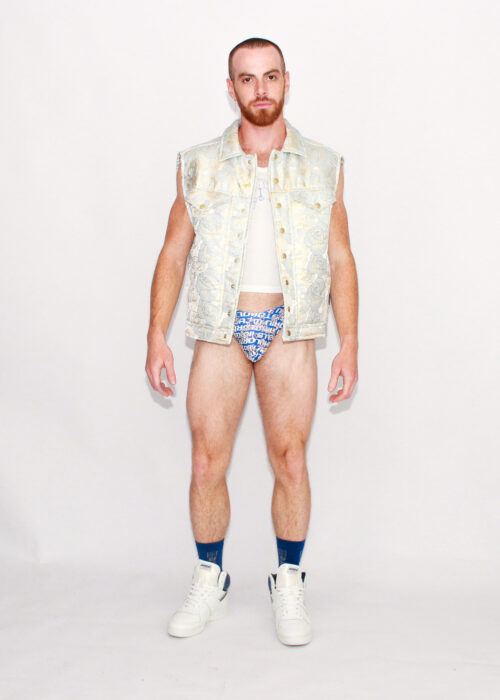
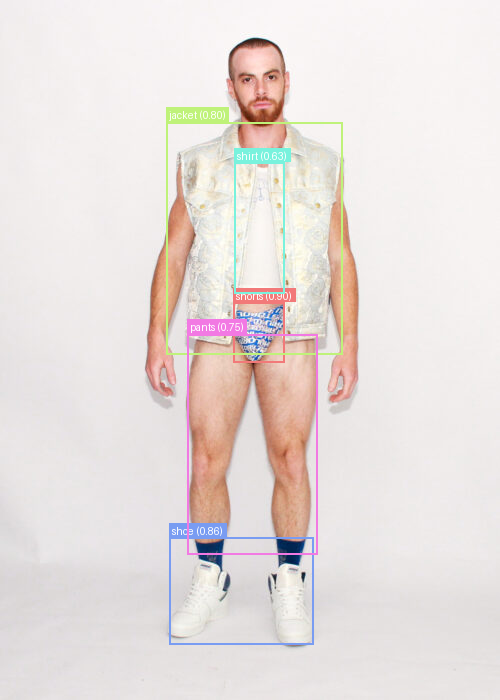
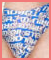
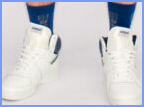
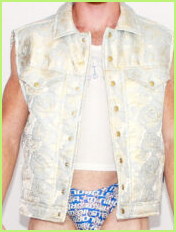
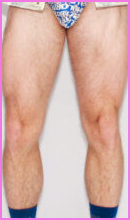
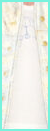



Testing product: City LS Tee: 72dd36fb91186a78feff87ba75b5bc1d

Top localizations for image cf04c86a7f7c780466726526d22e3aef:
	Localization: 114684db4859070c3fa54764a176a610, Distance: 1.2178
	Localization: f52ed5649bdd332ce7600858616d82ed, Distance: 1.2529
	Localization: 2de77f883692fb447c46f100f210dce4, Distance: 1.2773



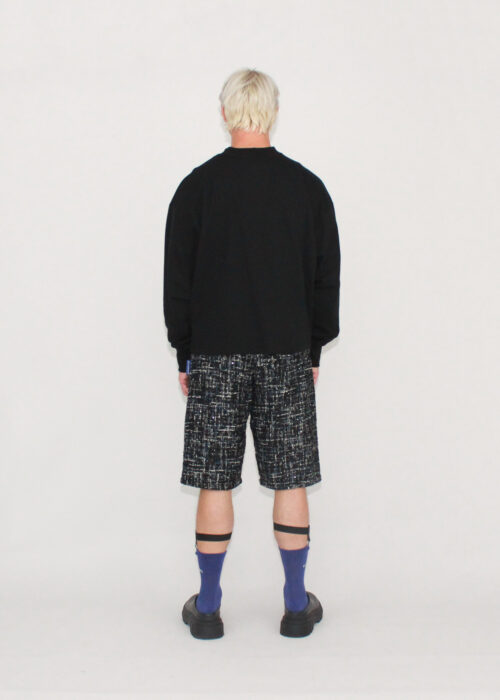
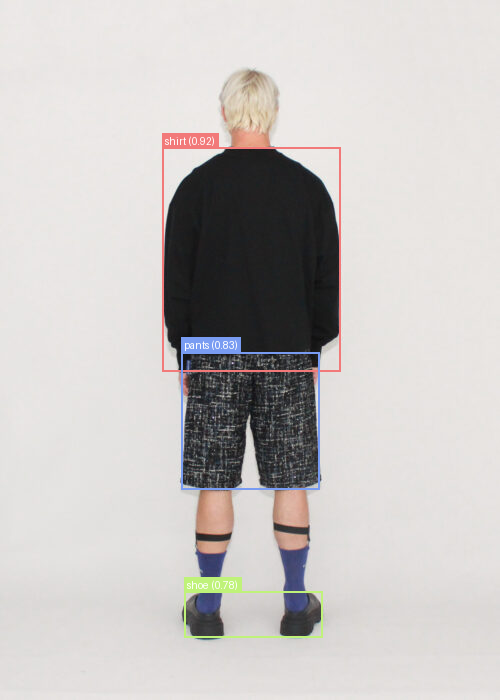
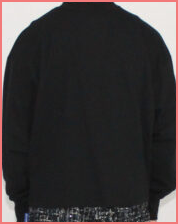
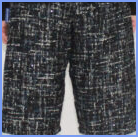
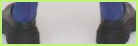



Testing product: agood phonecase: 691e296efcacc5e863da89215ab259c7



ValueError: 'a' cannot be empty unless no samples are taken

In [23]:
# Get random products with descriptions
products_with_desc = list(product_collection.find({
    "description": {"$ne": "NOT_FOUND"}
}))

# Test 5 random products
import random
random_products = random.sample(products_with_desc, 5)

for product in random_products:
    print("\n" + "="*80)
    print(f"\nTesting product: {product['title']}: {product['product_hash']}")
    print("="*80 + "\n")
    test_product(product)